# Úkol č. 2 - Využití neuronových sítí

  * **Deadline je 13. 5. 2024, 23:59:59**, pokud odevzdáte úkol do 20. 5. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.

  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [8]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import DataLoader
import random

import matplotlib.pyplot as plt

In [16]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

print("CUDA Available: ", torch.cuda.is_available())
print("cuDNN Enabled: ", torch.backends.cudnn.enabled)
print("cuDNN Version: ", torch.backends.cudnn.version())

# set up to use deterministic algorithms, so we have consistent results
torch.backends.cudnn.deterministic = True

CUDA Available:  True
cuDNN Enabled:  True
cuDNN Version:  8700


# Data Exploration

We will explore our data. We know that we have images in shades of grey (meaning we have only one channel). Images size is $32 \times 32$. Each image is represented as a row of pixels with label value.

Each training and test example is assigned to one of the following labels:

- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

In [49]:
labels_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
               7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [14]:
df_data = pd.read_csv('train.csv')

In [15]:
def split_data(data):
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    print(f'Images data shape: {images.shape}')
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_data(df_data)

Data shape: (52500, 1025)
Images data shape: (52500, 1024)
Train shape: (31500, 1024)
Validation shape: (21000, 1024)


We have high dimensionality data - $1024$ dimensions. For neural networks high dimensionality is not a concern, but lack of data can be. Luckily, we have quite a lot of images - $52500$ in the whole dataset. 

In [22]:
def explore_with_m_rd_columns(m=5):
    data_train_df = pd.concat((y_train, X_train), axis=1)
    random_indices = np.random.choice(range(1, data_train_df.shape[1]), m, replace=False)
    selected_indices = np.append(0, random_indices)
    selected_df = data_train_df.iloc[:, selected_indices]
    return selected_df


selection = explore_with_m_rd_columns(5)
selection.head()

,label,pix562,pix894,pix873,pix706,pix460
2262,3,170,2,4,2,129
25445,4,220,4,4,4,219
46043,7,80,0,0,0,193
12531,0,182,3,205,3,174
10152,5,62,0,0,0,174


In [23]:
selection.describe()

,label,pix562,pix894,pix873,pix706,pix460
count,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000
mean,4.526444,151.077111,1.135968,28.741714,1.180095,120.380794
std,2.867504,68.671474,5.106792,56.495310,4.749549,83.443700
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,105.000000,0.000000,0.000000,0.000000,35.000000
50%,5.000000,167.000000,0.000000,1.000000,0.000000,133.000000
75%,7.000000,205.000000,1.000000,23.000000,1.000000,195.000000
max,9.000000,255.000000,210.000000,255.000000,191.000000,255.000000


In [24]:
selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31500 entries, 2262 to 15795
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   31500 non-null  int64
 1   pix562  31500 non-null  int64
 2   pix894  31500 non-null  int64
 3   pix873  31500 non-null  int64
 4   pix706  31500 non-null  int64
 5   pix460  31500 non-null  int64
dtypes: int64(6)
memory usage: 1.7 MB


In [28]:
np.sort(y_train.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

From dataset analysis we see, that we have $10$ labels. We will look now at 10 random images from dataset for each label to visualize what our labels are.

In [40]:
indices = list()
for label in np.sort(y_train.unique()):
    indices.append(y_train[y_train == label].index[0])
selection_X_train, selection_y_train = X_train.loc[indices], y_train.loc[indices]

In [51]:
def draw_images(images, labels, shape, scale=1):
    images = images.to_numpy()
    labels = labels.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], 2 * i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], 2 * i + 2, xticks=[], yticks=[])
        image = images[i].reshape((32, 32))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title(f"{labels_dict[i]}\n(Y = {labels[i]})")

        i += 1

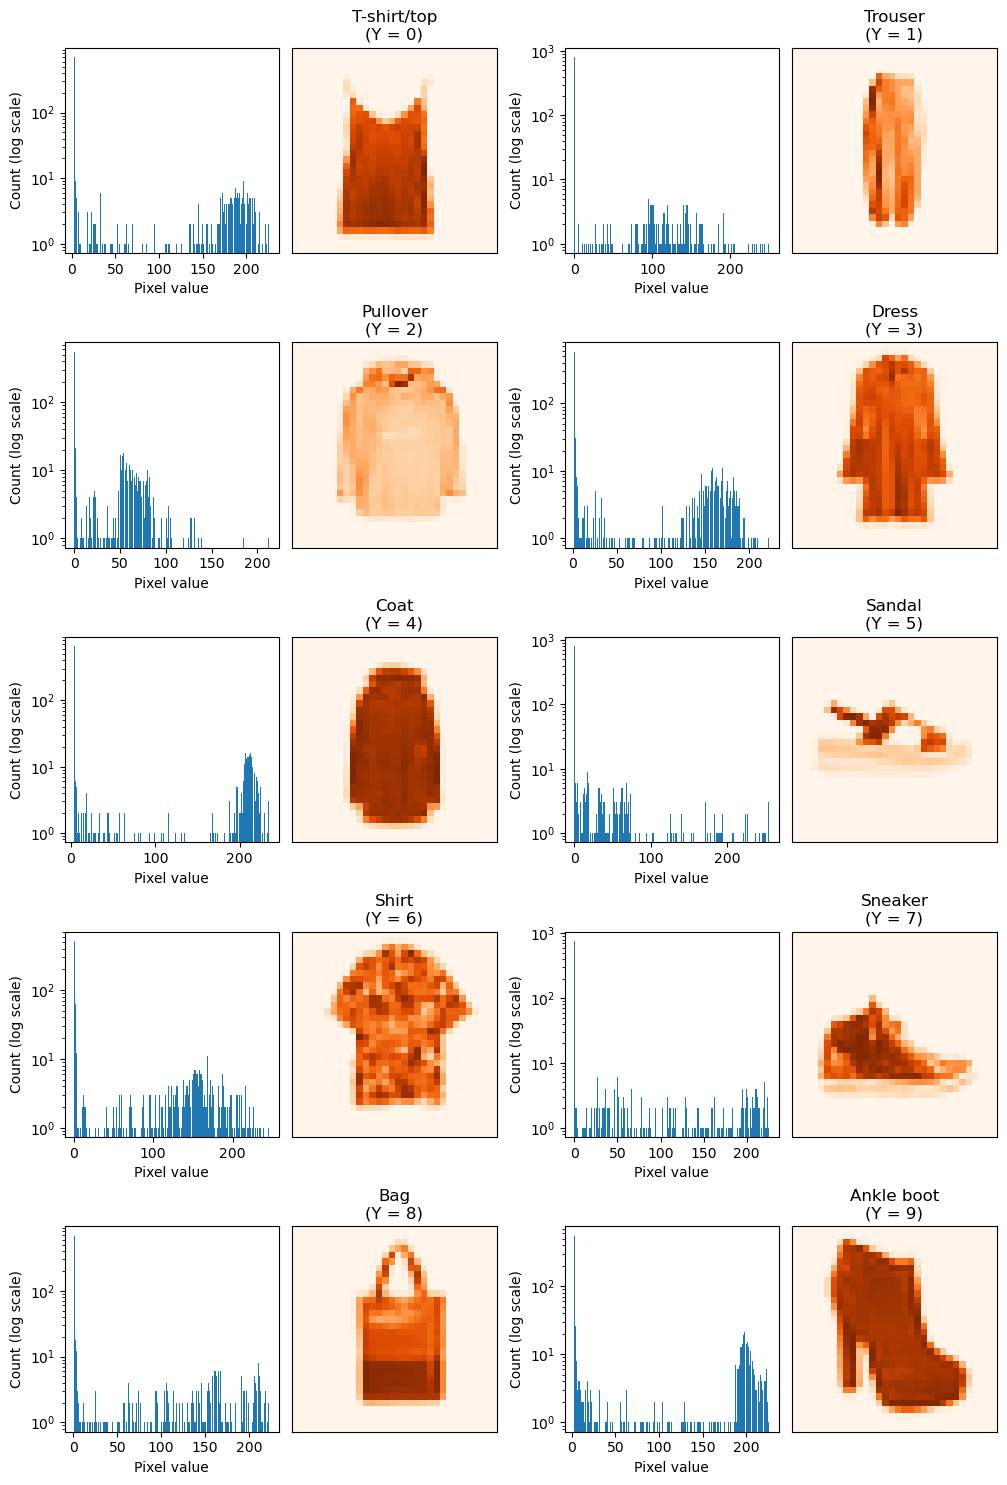

In [52]:
draw_images(selection_X_train, selection_y_train, shape=(5, 2), scale=2.5)

dict_values(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])


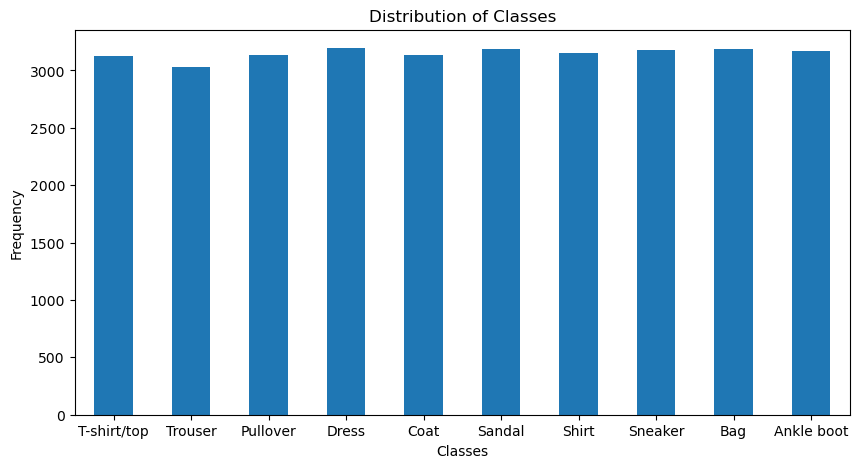

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
class_counts = y_train.value_counts().sort_index()
class_counts.plot(ax=ax, kind='bar')
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(class_counts.index, labels=labels_dict.values(), rotation=0)
plt.show()

We see that classes are distributed almost identically.

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB


We see, that to store the dataset in memory takes $410.6$ MB.

In [13]:
# release memory
del df_data, X_train, X_val, y_train, y_val

In [29]:
def get_torch_dataset():
    df_images = df_data.drop('label', axis=1).to_numpy()
    df_labels = df_data['label'].to_numpy()
    dataset = torch.utils.data.TensorDataset(torch.Tensor(df_images, dtype=torch.float),
                                             torch.tensor(df_labels, dtype=torch.int))
    return dataset


df_data = get_torch_dataset()

TypeError: new() received an invalid combination of arguments - got (numpy.ndarray, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)
